### Ethnicolr: NC Voter Registration Name Model (Race only)

We build a separate model that only predicts the race_code and takes out 'U', again assuming it to be 'missing at random.'

In [1]:
from __future__ import print_function

import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

In [2]:
NGRAMS = (2, 3)
SAMPLE = 1000000
EPOCHS = 15

# Florida voter
df = pd.read_csv('/opt/data/nc_voter/nc_voter_name_gender_race_ethnic_age.csv', usecols=['last_name', 'first_name', 'race_code'], nrows=SAMPLE * 2)
df.dropna(subset=['first_name', 'last_name'], inplace=True)

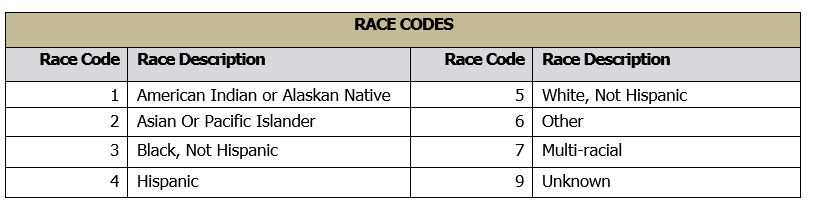

### Drop U and UN from race and ethnic.

In [3]:
df.drop(df[df.race_code=='U'].index, inplace=True)
df

,last_name,first_name,race_code
0,AABEL,EVELYN,W
1,AARON,CHRISTINA,W
2,AARON,CLAUDIA,W
3,AARON,JAMES,W
4,AARON,NATHAN,W
5,AARON,RICHARD,W
6,AARON,SANDRA,W
7,AARON,WILLIE,W
8,AARONSON,GENA,W
9,AARONSON,MICHAEL,W


In [4]:
df.groupby(['race_code']).size()

race_code
A      16176
B     376291
I       7761
M      12004
O      41580
W    1482050
dtype: int64

In [5]:
df['race'] = df['race_code']
df

,last_name,first_name,race_code,race
0,AABEL,EVELYN,W,W
1,AARON,CHRISTINA,W,W
2,AARON,CLAUDIA,W,W
3,AARON,JAMES,W,W
4,AARON,NATHAN,W,W
5,AARON,RICHARD,W,W
6,AARON,SANDRA,W,W
7,AARON,WILLIE,W,W
8,AARONSON,GENA,W,W
9,AARONSON,MICHAEL,W,W


In [6]:
df.drop_duplicates(inplace=True)

In [7]:
df.groupby(['race']).size()

race
A     15262
B    293173
I      7356
M     11844
O     39305
W    991209
dtype: int64

In [8]:
max_size = df['race'].value_counts().max()
lst = [df]
for class_index, group in df.groupby('race'):
    lst.append(group.sample(max_size-len(group), replace=True))
odf = pd.concat(lst)
odf

,last_name,first_name,race_code,race
0,AABEL,EVELYN,W,W
1,AARON,CHRISTINA,W,W
2,AARON,CLAUDIA,W,W
3,AARON,JAMES,W,W
4,AARON,NATHAN,W,W
5,AARON,RICHARD,W,W
6,AARON,SANDRA,W,W
7,AARON,WILLIE,W,W
8,AARONSON,GENA,W,W
9,AARONSON,MICHAEL,W,W


In [9]:
odf.groupby('race').agg({'first_name': 'count'})

,first_name
race,
A,991209
B,991209
I,991209
M,991209
O,991209
W,991209


In [10]:
sdf = odf.sample(SAMPLE, random_state=21)
sdf

,last_name,first_name,race_code,race
244479,GAY,GEORGE,B,B
1988842,JUNG,KATHERINE,A,A
1877347,BAKER,CHRISTAIN,W,W
1905838,CATES,JEAN,B,B
674689,XIONG,BLIA,A,A
1285432,PATRICK,RAYMOND,I,I
1461253,GRADY,ERIC,B,B
1224561,LONDON,TAMMY,W,W
746879,KESLER,ALLAN,W,W
672614,WILKERSON,JONISHA,M,M


In [11]:
# Additional features
sdf['first_name'] = sdf.first_name.str.title()
sdf['last_name'] = sdf.last_name.str.title()

sdf.groupby('race').agg({'first_name': 'count'})

,first_name
race,
A,166890
B,166431
I,166462
M,166516
O,166334
W,167367


## Preprocessing the input data

In [12]:
%%time
# concat last name and first name
sdf['last_name_first_name'] = sdf['last_name'] + ' ' + sdf['first_name']

# build n-gram list
vect = CountVectorizer(analyzer='char', max_df=0.3, min_df=10, ngram_range=NGRAMS, lowercase=False) 
a = vect.fit_transform(sdf.last_name_first_name)
vocab = vect.vocabulary_

# sort n-gram by freq (highest -> lowest)
words = []
for b in vocab:
    c = vocab[b]
    #print(b, c, a[:, c].sum())
    words.append((a[:, c].sum(), b))
    #break
words = sorted(words, reverse=True)
words_list = [w[1] for w in words]
num_words = len(words_list)
print("num_words = %d" % num_words)

num_words = 12855
CPU times: user 52min 15s, sys: 668 ms, total: 52min 16s
Wall time: 52min 17s


In [13]:
vocab

{'Ga': 1805,
 'ay': 5130,
 'y ': 12308,
 ' G': 103,
 'Ge': 1828,
 'eo': 6317,
 'or': 9793,
 'rg': 10402,
 'ge': 6808,
 'Gay': 1824,
 'ay ': 5131,
 'y G': 12316,
 ' Ge': 105,
 'Geo': 1840,
 'eor': 6334,
 'org': 9802,
 'rge': 10405,
 'Ju': 2383,
 'un': 11682,
 'ng': 9140,
 'g ': 6717,
 ' K': 169,
 'Ka': 2414,
 'at': 5029,
 'th': 11178,
 'he': 7121,
 'er': 6362,
 'ri': 10424,
 'in': 7649,
 'ne': 9104,
 'Jun': 2396,
 'ung': 11691,
 'ng ': 9141,
 'g K': 6728,
 ' Ka': 172,
 'Kat': 2435,
 'ath': 5036,
 'the': 11184,
 'her': 7140,
 'eri': 6373,
 'rin': 10440,
 'ine': 7656,
 'Ba': 988,
 'ak': 4812,
 'ke': 8086,
 'r ': 10237,
 ' C': 43,
 'Ch': 1184,
 'hr': 7271,
 'is': 7748,
 'st': 10979,
 'ta': 11095,
 'ai': 4762,
 'Bak': 999,
 'ake': 4818,
 'ker': 8102,
 'er ': 6363,
 'r C': 10240,
 ' Ch': 47,
 'Chr': 1192,
 'hri': 7276,
 'ris': 10445,
 'ist': 7766,
 'sta': 10982,
 'tai': 11106,
 'ain': 4777,
 'Ca': 1146,
 'te': 11138,
 'es': 6390,
 's ': 10697,
 ' J': 154,
 'Je': 2303,
 'ea': 6028,
 'an': 488

In [14]:
from itertools import chain

def n_grams(seq, n=1):
    """Returns an itirator over the n-grams given a listTokens"""
    shiftToken = lambda i: (el for j,el in enumerate(seq) if j>=i)
    shiftedTokens = (shiftToken(i) for i in range(n))
    tupleNGrams = zip(*shiftedTokens)
    return tupleNGrams # if join in generator : (" ".join(i) for i in tupleNGrams)

def range_ngrams(listTokens, ngramRange=(1,2)):
    """Returns an itirator over all n-grams for n in range(ngramRange) given a listTokens."""
    ngrams = (ngramRange[0], ngramRange[1] + 1)
    return chain(*(n_grams(listTokens, i) for i in range(*ngramRange)))

In [15]:
%%time
def find_ngrams(text, ngrams):
    a = range_ngrams(text, ngrams)
    wi = []
    for i in a:
        w = ''.join(i)
        try:
            idx = words_list.index(w)
        except:
            idx = 0
        wi.append(idx)
    return wi

# build X from index of n-gram sequence
X = np.array(sdf.last_name_first_name.apply(lambda c: find_ngrams(c, NGRAMS)))

# check max/avg feature
X_len = []
for x in X:
    X_len.append(len(x))

max_feature_len = max(X_len)
avg_feature_len = int(np.mean(X_len))

print("Max feature len = %d, Avg. feature len = %d" % (max_feature_len, avg_feature_len))
y = np.array(sdf.race.astype('category').cat.codes)

# Split train and test dataset
X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)

Max feature len = 37, Avg. feature len = 12
CPU times: user 1min 46s, sys: 508 ms, total: 1min 46s
Wall time: 1min 46s


## Train a LSTM model

ref: http://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

In [16]:
'''The dataset is actually too small for LSTM to be of any advantage
compared to simpler, much faster methods such as TF-IDF + LogReg.
Notes:

- RNNs are tricky. Choice of batch size is important,
choice of loss and optimizer is critical, etc.
Some configurations won't converge.

- LSTM loss decrease patterns during training can be quite different
from what you see with CNNs/MLPs/etc.
'''
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, Activation
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.models import load_model

max_features = num_words # 20000
feature_len = 25 # avg_feature_len # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

print('Pad sequences (samples x time)')
X_train = sequence.pad_sequences(X_train, maxlen=feature_len)
X_test = sequence.pad_sequences(X_test, maxlen=feature_len)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

num_classes = np.max(y_train) + 1
print(num_classes, 'classes')

print('Convert class vector to binary class matrix '
      '(for use with categorical_crossentropy)')
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

Using TensorFlow backend.


800000 train sequences
200000 test sequences
Pad sequences (samples x time)
X_train shape: (800000, 25)
X_test shape: (200000, 25)
6 classes
Convert class vector to binary class matrix (for use with categorical_crossentropy)
y_train shape: (800000, 6)
y_test shape: (200000, 6)


In [17]:
print('Build model...')

if False:
    model = Sequential()
    model.add(Embedding(num_words, 32, input_length=feature_len))
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(num_classes, activation='softmax'))
if True:
    embedding_vecor_length = 50
    model = Sequential()
    model.add(Embedding(num_words, embedding_vecor_length, input_length=feature_len))
    model.add(Conv1D(activation="relu", padding="same", filters=32, kernel_size=3))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(100))
    model.add(Dense(num_classes, activation='softmax'))

# try using different optimizers and different optimizer configs
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

Build model...






_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 25, 50)            642750    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 25, 32)            4832      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 12, 32)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 606       
Total params: 701,388
Trainable params: 701,388
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
%%time
print('Train...')
model.fit(X_train, y_train, batch_size=batch_size, epochs=EPOCHS,
          validation_split=0.1, verbose=1)
score, acc = model.evaluate(X_test, y_test,
                            batch_size=batch_size, verbose=1)
print('Test score:', score)
print('Test accuracy:', acc)

Train...
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 720000 samples, validate on 80000 samples
Epoch 1/15





720000/720000 [==============================] - 584s 812us/step - loss: 1.3442 - acc: 0.4720 - val_loss: 1.2440 - val_acc: 0.5135
Epoch 2/15
720000/720000 [==============================] - 574s 798us/step - loss: 1.1483 - acc: 0.5572 - val_loss: 1.0726 - val_acc: 0.5884
Epoch 3/15
720000/720000 [==============================] - 519s 721us/step - loss: 0.9765 - acc: 0.6293 - val_loss: 0.9428 - val_acc: 0.6432
Epoch 4/15
720000/720000 [==============================] - 531s 737us/step - loss: 0.8691 - acc: 0.6733 - val_loss: 0.8727 - val_acc: 0.6717
Epoch 5/15
720000/720000 [==============================] - 535s 744us/step - loss: 0.8091 - acc: 0.6956 - val_loss: 0.8265 - val_acc: 0.6893
Epoch 6/15
720000/720000 [==============================] - 505s 701us/step - loss: 0.7731 - acc: 0.7093 - val_loss: 0.8118 - va

In [19]:
print('Test score:', score)
print('Test accuracy:', acc)

Test score: 0.759171972079277
Test accuracy: 0.71554


## Confusion Matrix

In [20]:
y_pred = model.predict_classes(X_test, verbose=2)
p = model.predict_proba(X_test, verbose=2) # to predict probability
target_names = list(sdf.race.astype('category').cat.categories)
print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names))

              precision    recall  f1-score   support

           A       0.82      0.90      0.86     33378
           B       0.56      0.58      0.57     33286
           I       0.85      0.93      0.89     33292
           M       0.75      0.82      0.78     33303
           O       0.75      0.57      0.65     33267
           W       0.54      0.50      0.52     33474

    accuracy                           0.72    200000
   macro avg       0.71      0.72      0.71    200000
weighted avg       0.71      0.72      0.71    200000



In [21]:
conf_mat = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
print(conf_mat)

[[30080   843   249   289   994   923]
 [ 1089 19188  1823  3332  1273  6581]
 [  240   806 30833   365   186   862]
 [  270  2275   477 27274  1426  1581]
 [ 3402  3795   707  2006 18871  4486]
 [ 1685  7403  2002  3231  2291 16862]]


In [22]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

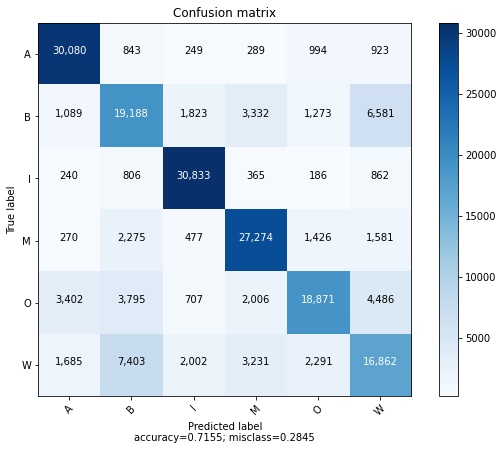

In [23]:
plot_confusion_matrix(conf_mat, target_names, normalize=False)

### Save model

In [24]:
#model.save('../models/nc_voter_name_lstm.h5')
model.save('/opt/github/ethnicolr/ethnicolr/models/nc_voter_reg/nc_voter_name_race_lstm_oversample.h5')

In [25]:
words_df = pd.DataFrame(words_list, columns=['vocab'])
#words_df.to_csv('../models/nc_voter_name_vocab.csv', index=False, encoding='utf-8')
words_df.to_csv('/opt/github/ethnicolr/ethnicolr/models/nc_voter_reg/nc_voter_name_race_vocab_oversample.csv', index=False, encoding='utf-8')